# PySpark PyTorch Inference

### Image Classification
Based on: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

In [1]:
import torch

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
torch.__version__

'2.0.1+cpu'

In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [5]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {X.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28]) torch.float32
Shape of y: torch.Size([64]) torch.int64


### Create model

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Train Model

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.305429  [    0/60000]
loss: 2.297022  [ 6400/60000]
loss: 2.266470  [12800/60000]
loss: 2.265714  [19200/60000]
loss: 2.253563  [25600/60000]
loss: 2.203140  [32000/60000]
loss: 2.224580  [38400/60000]
loss: 2.182435  [44800/60000]
loss: 2.177402  [51200/60000]
loss: 2.141706  [57600/60000]
Test Error: 
 Accuracy: 20.4%, Avg loss: 2.142049 

Epoch 2
-------------------------------
loss: 2.150640  [    0/60000]
loss: 2.147359  [ 6400/60000]
loss: 2.082054  [12800/60000]
loss: 2.101886  [19200/60000]
loss: 2.044116  [25600/60000]
loss: 1.972289  [32000/60000]
loss: 2.005282  [38400/60000]
loss: 1.923009  [44800/60000]
loss: 1.926389  [51200/60000]
loss: 1.847295  [57600/60000]
Test Error: 
 Accuracy: 54.4%, Avg loss: 1.854991 

Epoch 3
-------------------------------
loss: 1.888080  [    0/60000]
loss: 1.862951  [ 6400/60000]
loss: 1.743250  [12800/60000]
loss: 1.784036  [19200/60000]
loss: 1.660822  [25600/60000]
loss: 1.621519  [32000/600

### Save Model State Dict
This is the [currently recommended save format](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference).

In [11]:
torch.save(model.state_dict(), "model_weights.pt")
print("Saved PyTorch Model State to model_weights.pt")

Saved PyTorch Model State to model_weights.pt


### Save Entire Model
This saves the entire model using python pickle, but has the [following disadvantage](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-entire-model):
> The serialized data is bound to the specific classes and the exact directory structure used when the model is saved... Because of this, your code can break in various ways when used in other projects or after refactors.

In [12]:
torch.save(model, "model.pt")

### Save Model as TorchScript
This saves an [intermediate representation of the compute graph](https://pytorch.org/tutorials/beginner/saving_loading_models.html#export-load-model-in-torchscript-format), which does not require pickle (or even python).  However, this currently doesn't work with spark, which uses pickle serialization.

In [13]:
scripted = torch.jit.script(model)

In [14]:
scripted.save("model.ts")

### Load Model State

In [15]:
model_from_state = NeuralNetwork()
model_from_state.load_state_dict(torch.load("model_weights.pt"))

<All keys matched successfully>

In [16]:
model_from_state.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model_from_state(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


### Load Model

In [17]:
new_model = torch.load("model.pt")

In [18]:
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = new_model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


### Load Torchscript Model

In [19]:
ts_model = torch.jit.load("model.ts")

In [20]:
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = ts_model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


## PySpark

### Convert numpy dataset to Pandas DataFrame

In [21]:
import pandas as pd
from pyspark.sql.types import StructType, StructField, ArrayType, FloatType

In [22]:
data = test_data.data.numpy()
data.shape, data.dtype

((10000, 28, 28), dtype('uint8'))

In [23]:
data = data.reshape(10000, 784) / 255.0
data.shape, data.dtype

((10000, 784), dtype('float64'))

In [24]:
pdf784 = pd.DataFrame(data)
pdf784

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.007843,0.011765,0.0,0.011765,0.682353,0.741176,0.262745,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.003922,0.000000,...,0.643137,0.227451,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.082353,...,0.003922,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.007843,0.0,0.003922,0.003922,0.0,0.000000,0.000000,...,0.278431,0.047059,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.121569,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.105882,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [25]:
%%time
# 1 column of array<float>
pdf1 = pd.DataFrame()
pdf1['data'] = pdf784.values.tolist()
pdf1

CPU times: user 178 ms, sys: 52.5 ms, total: 231 ms
Wall time: 227 ms


,data
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.0, 0.0, 0.0, 0.00784313725490196, 0.0, 0.00..."
...,...
9995,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9996,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9997,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9998,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [26]:
### Create Spark DataFrame from Pandas DataFrame

In [27]:
%%time
# force FloatType since Spark defaults to DoubleType
schema = StructType([StructField("data",ArrayType(FloatType()), True)])
df = spark.createDataFrame(pdf1, schema)

CPU times: user 3.33 s, sys: 68.3 ms, total: 3.4 s
Wall time: 5.51 s


In [28]:
df.schema

StructType([StructField('data', ArrayType(FloatType(), True), True)])

In [29]:
%%time
# force FloatType since Spark defaults to DoubleType
schema = StructType([StructField(str(x), FloatType(), True) for x in range(784)])
df784 = spark.createDataFrame(pdf784, schema)

CPU times: user 4.35 s, sys: 141 ms, total: 4.5 s
Wall time: 4.75 s


### Save the test dataset as parquet files

In [30]:
%%time
df.write.mode("overwrite").parquet("fashion_mnist_1")

23/05/19 17:55:11 WARN TaskSetManager: Stage 0 contains a task of very large size (7070 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 5.9 ms, sys: 4.12 ms, total: 10 ms
Wall time: 4.31 s


In [31]:
%%time
df784.write.mode("overwrite").parquet("fashion_mnist_784")

23/05/19 17:55:14 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/05/19 17:55:14 WARN TaskSetManager: Stage 1 contains a task of very large size (7067 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 11.9 ms, sys: 54 µs, total: 12 ms
Wall time: 2.93 s


### Check arrow memory configuration

In [32]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "128")
# This line will fail if the vectorized reader runs out of memory
assert len(df.head()) > 0, "`df` should not be empty"

23/05/19 17:55:17 WARN TaskSetManager: Stage 2 contains a task of very large size (7070 KiB). The maximum recommended task size is 1000 KiB.


## Inference using Spark DL API

### 1 columns of 784 float

In [33]:
import numpy as np

from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import struct, col, array
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

In [34]:
df = spark.read.parquet("fashion_mnist_1")
len(df.columns)

1

In [35]:
df.schema

StructType([StructField('data', ArrayType(FloatType(), True), True)])

In [36]:
# get absolute path to model
model_dir = "{}/model.ts".format(os.getcwd())

In [37]:
def predict_batch_fn():
    import torch
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using {} device".format(device))
    model = torch.jit.load(model_dir)
    model.to(device)
    
    def predict(inputs: np.ndarray):
        torch_inputs = torch.from_numpy(inputs).to(device)
        outputs = model(torch_inputs)
        return outputs.detach().numpy()
    
    return predict

In [38]:
mnist = predict_batch_udf(predict_batch_fn,
                          input_tensor_shapes=[[784]],
                          return_type=ArrayType(FloatType()),
                          batch_size=50)

In [39]:
%%time
# first pass caches model/fn
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

CPU times: user 465 ms, sys: 117 ms, total: 582 ms
Wall time: 4.31 s


In [40]:
%%time
preds = df.withColumn("preds", mnist(*df.columns)).collect()

CPU times: user 449 ms, sys: 125 ms, total: 574 ms
Wall time: 1.48 s


In [41]:
%%time
preds = df.withColumn("preds", mnist(*[col(c) for c in df.columns])).collect()

CPU times: user 698 ms, sys: 117 ms, total: 815 ms
Wall time: 1.52 s


### Check predictions

In [42]:
predictions = preds[0].preds
img = preds[0].data

In [43]:
import matplotlib.pyplot as plt
import numpy as np

In [44]:
img = np.array(img).reshape(28,28)

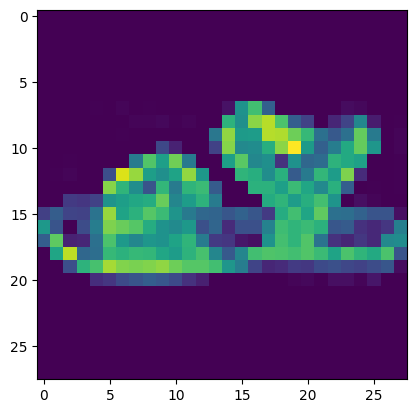

In [45]:
plt.figure()
plt.imshow(img)
plt.show()

In [46]:
predictions

[-1.7200822830200195,
 -2.013300895690918,
 -0.3198302984237671,
 -1.4132847785949707,
 -0.25933510065078735,
 1.7492953538894653,
 -0.45816969871520996,
 2.1313018798828125,
 1.6222647428512573,
 1.3297781944274902]

### 784 columns of float

In [47]:
df = spark.read.parquet("fashion_mnist_784")
len(df.columns)

784

In [48]:
%%time
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

CPU times: user 1.08 s, sys: 142 ms, total: 1.23 s
Wall time: 6 s


In [49]:
%%time
preds = df.withColumn("preds", mnist(array(*df.columns))).collect()

CPU times: user 1.07 s, sys: 137 ms, total: 1.21 s
Wall time: 3.01 s


In [50]:
# should raise ValueError
# preds = df.withColumn("preds", mnist(*df.columns)).collect()

### Check predictions

In [51]:
preds = df.withColumn("preds", mnist(array(*df.columns))).limit(10).toPandas()

In [52]:
sample = preds.iloc[0]
predictions = sample.preds
img = sample.drop('preds').to_numpy(dtype=float)

In [53]:
import matplotlib.pyplot as plt
import numpy as np

In [54]:
img = np.array(img).reshape(28,28)

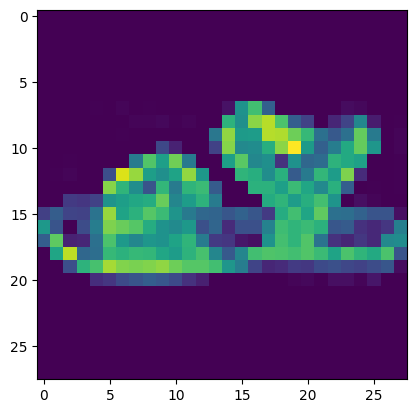

In [55]:
plt.figure()
plt.imshow(img)
plt.show()

In [56]:
predictions

[-1.720082402229309,
 -2.013301134109497,
 -0.3198302984237671,
 -1.4132847785949707,
 -0.25933507084846497,
 1.7492954730987549,
 -0.4581696689128876,
 2.1313018798828125,
 1.6222645044326782,
 1.3297783136367798]

### Using Triton Inference Server

Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [57]:
import numpy as np

from functools import partial
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import struct, col, array
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

In [58]:
%%bash
# copy model to expected layout for Triton
rm -rf models
mkdir -p models/fashion_mnist/1
cp model.ts models/fashion_mnist/1/model.pt

# add config.pbtxt
cp models_config/fashion_mnist/config.pbtxt models/fashion_mnist/config.pbtxt

#### Start Triton Server on each executor

In [59]:
num_executors = 1
triton_models_dir = "{}/models".format(os.getcwd())
nodeRDD = sc.parallelize(list(range(num_executors)), num_executors)

def start_triton(it):
    import docker
    import time
    import tritonclient.grpc as grpcclient
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    if containers:
        print(">>>> containers: {}".format([c.short_id for c in containers]))
    else:
        container=client.containers.run(
            "nvcr.io/nvidia/tritonserver:22.07-py3", "tritonserver --model-repository=/models",
            detach=True,
            device_requests=[docker.types.DeviceRequest(device_ids=["0"], capabilities=[['gpu']])],
            name="spark-triton",
            network_mode="host",
            remove=True,
            shm_size="64M",
            volumes={triton_models_dir: {"bind": "/models", "mode": "ro"}}
        )
        print(">>>> starting triton: {}".format(container.short_id))

        # wait for triton to be running
        time.sleep(15)
        client = grpcclient.InferenceServerClient("localhost:8001")
        ready = False
        while not ready:
            try:
                ready = client.is_server_ready()
            except Exception as e:
                time.sleep(5)
            
    return [True]

nodeRDD.barrier().mapPartitions(start_triton).collect()

[True]

#### Run inference

In [60]:
df = spark.read.parquet("fashion_mnist_1")
len(df.columns)

1

In [61]:
df.schema

StructType([StructField('data', ArrayType(FloatType(), True), True)])

In [62]:
def triton_fn(triton_uri, model_name):
    import numpy as np
    import tritonclient.grpc as grpcclient
    
    np_types = {
      "BOOL": np.dtype(np.bool8),
      "INT8": np.dtype(np.int8),
      "INT16": np.dtype(np.int16),
      "INT32": np.dtype(np.int32),
      "INT64": np.dtype(np.int64),
      "FP16": np.dtype(np.float16),
      "FP32": np.dtype(np.float32),
      "FP64": np.dtype(np.float64),
      "FP64": np.dtype(np.double),
      "BYTES": np.dtype(object)
    }

    client = grpcclient.InferenceServerClient(triton_uri)
    model_meta = client.get_model_metadata(model_name)
    
    def predict(inputs):
        if isinstance(inputs, np.ndarray):
            # single ndarray input
            request = [grpcclient.InferInput(model_meta.inputs[0].name, inputs.shape, model_meta.inputs[0].datatype)]
            request[0].set_data_from_numpy(inputs.astype(np_types[model_meta.inputs[0].datatype]))
        else:
            # dict of multiple ndarray inputs
            request = [grpcclient.InferInput(i.name, inputs[i.name].shape, i.datatype) for i in model_meta.inputs]
            for i in request:
                i.set_data_from_numpy(inputs[i.name()].astype(np_types[i.datatype()]))
        
        response = client.infer(model_name, inputs=request)
        
        if len(model_meta.outputs) > 1:
            # return dictionary of numpy arrays
            return {o.name: response.as_numpy(o.name) for o in model_meta.outputs}
        else:
            # return single numpy array
            return response.as_numpy(model_meta.outputs[0].name)
        
    return predict

In [63]:
mnist = predict_batch_udf(partial(triton_fn, triton_uri="localhost:8001", model_name="fashion_mnist"),
                          input_tensor_shapes=[[784]],
                          return_type=ArrayType(FloatType()),
                          batch_size=1024)

In [64]:
%%time
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

CPU times: user 491 ms, sys: 60.7 ms, total: 551 ms
Wall time: 1.98 s


In [65]:
%%time
preds = df.withColumn("preds", mnist(*df.columns)).collect()

CPU times: user 817 ms, sys: 89 ms, total: 906 ms
Wall time: 1.44 s


In [66]:
%%time
preds = df.withColumn("preds", mnist(*[col(c) for c in df.columns])).collect()

CPU times: user 460 ms, sys: 105 ms, total: 565 ms
Wall time: 1.11 s


#### Stop Triton Server on each executor

In [67]:
def stop_triton(it):
    import docker
    import time
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    print(">>>> stopping containers: {}".format([c.short_id for c in containers]))
    if containers:
        container=containers[0]
        container.stop(timeout=120)

    return [True]

nodeRDD.barrier().mapPartitions(stop_triton).collect()

[True]

In [68]:
spark.stop()